In [1]:
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import pg_fitter_tools as fit
import sk_geo_tools as sk
import plotly.graph_objects as go
import pickle

In [4]:
%matplotlib notebook

In [5]:
def plot(data, op, s,c, n):
    return go.Scatter3d(
    x=data[:,0], 
    y=data[:,1], 
    z=data[:,2], 
    marker=go.scatter3d.Marker(size=s,color = c), 
    #marker=dict(
    #        color=c,
    #        size=3,
    #    ), 
    opacity=op, 
    mode='markers',
    name = n)

## Camera Settings

In [6]:
focal_length = np.array([2.760529621789217e+03, 2.767014510543478e+03])
principle_point = np.array([1.914303537872458e+03, 1.596386868474348e+03])
radial_distortion = np.array([-0.2398, 0.1145])
tangential_distortion = np.array([0, 0])

## Load data from files
* Load all PMT locations
* Load image feature locations

In [7]:
all_pmt_locations = fit.read_3d_feature_locations("parameters/SK_all_PMT_locations.txt")
offset = np.array([0, 250])
images = [755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,
          774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,
          793,794,795,796,797,798,799,800,801,901,902,903,904]

imageExtension = ".jpg"
imageLocation = "source/ring_images/"

textLocation = "source/ring_points/"
textExtension = "_labels_all.txt"

saveLocation = "results/full_ring/"
image_feature_locations = {}
for image in images:
    image = str(image)
    image_feature_locations.update(
        fit.read_image_feature_locations(
            textLocation+image+textExtension, offset=offset))

In [8]:
# choose features that appear in 2+ 
feature_counts = Counter([f for i in image_feature_locations.values() for f in i.keys()])
common_features = [f for f in feature_counts if feature_counts[f] > 1]
pmt_locations = {k: p for k, p in all_pmt_locations.items() if k in common_features}

In [9]:
# generate bolt locations from PMT locations
bolt_locations = sk.get_bolt_locations_barrel(pmt_locations)
common_bolt_locations = {k: b for k, b in bolt_locations.items() if k in common_features}

common_feature_locations = {**pmt_locations, **bolt_locations} # replaced
common_feature_locations = {**pmt_locations}

common_image_pmt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in pmt_locations}
    for k, i in image_feature_locations.items()}
common_image_feature_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in common_feature_locations}
    for k, i in image_feature_locations.items()}
common_image_bolt_locations = {
    k: {j: f for j, f in i.items() if j in common_features and j in bolt_locations}
    for k, i in image_feature_locations.items()}
nimages = len(common_image_feature_locations)
nfeatures = len(common_feature_locations)
print(nimages, nfeatures)

51 674


## Plot seed positions for PMTs and bolts

In [10]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], bolt_array[:,2], marker='.', label="bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], pmt_array[:,2], marker='^', label="pmt (seed position)")
for i, f in enumerate(pmt_locations.keys()):
    ax.text(pmt_array[i,0], pmt_array[i,1], pmt_array[i,2], f[:5], size=8, zorder=4, color='k') 
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>

In [11]:
fig = go.Figure()

fig.add_trace(plot(bolt_array,0.7,1,"blue","bolt (seed position)"))
#fig.add_trace(plot(pmt_array,0.9,1,"orange","pmt (seed position)"))


for i, f in enumerate(pmt_locations.keys()):
    #print(pmt_array[i,0])
    fig.add_trace(go.Scatter3d(
        x=[pmt_array[i,0]], 
        y=[pmt_array[i,1]], 
        z=[pmt_array[i,2]], 
        marker=go.scatter3d.Marker(size=3,color = "orange", opacity=0.9), 
        opacity=1, 
        mode='markers',
        name = f[:5], hovertemplate="pmt (seed position) ", showlegend=False))

fig.show()

In [12]:
fig, ax = plt.subplots(figsize=(9,9))
bolt_array = np.stack(list(bolt_locations.values()))
pmt_array = np.stack(list(pmt_locations.values()))
ax.scatter(bolt_array[:,0], bolt_array[:,1], marker='.', label="bolt (seed position)")
ax.scatter(pmt_array[:,0], pmt_array[:,1], marker='^', label="pmt (seed position)")
ax.set_ylim((500,1050))
ax.set_xlim((1200,1800))
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>

## Create fitter objects

In [13]:
fitter_pmts = fit.PhotogrammetryFitter(common_image_pmt_locations, pmt_locations,
                                       focal_length, principle_point, radial_distortion)
fitter_bolts = fit.PhotogrammetryFitter(common_image_bolt_locations, common_bolt_locations,
                                       focal_length, principle_point, radial_distortion)
fitter_all = fit.PhotogrammetryFitter(common_image_feature_locations, common_feature_locations,
                                       focal_length, principle_point, radial_distortion)

51 images with total of  674 features
51 images with total of  0 features
51 images with total of  674 features



## Estimate camera poses assuming seed feature positions

In [14]:
camera_rotations, camera_translations, reprojected_points = fitter_all.estimate_camera_poses(flags=cv2.SOLVEPNP_EPNP)

image 0 reprojection errors:    average: 7.298302664313666    max: 25.3707478253907
image 1 reprojection errors:    average: 6.043695822676118    max: 22.020255598839636
image 2 reprojection errors:    average: 5.622339698056417    max: 17.738566384131204
image 3 reprojection errors:    average: 9.585391214604513    max: 25.151082906806298
image 4 reprojection errors:    average: 5.244403216476958    max: 26.305640493172692
image 5 reprojection errors:    average: 5.3365799104272345    max: 16.88488218789326
image 6 reprojection errors:    average: 7.020667533914002    max: 30.226880653866214
image 7 reprojection errors:    average: 7.330845288314409    max: 16.208971797590007
image 8 reprojection errors:    average: 9.059571278715888    max: 28.035307114972134
image 9 reprojection errors:    average: 7.881172706789551    max: 33.66435520588311
image 10 reprojection errors:    average: 5.564381999754655    max: 17.033889446007233
image 11 reprojection errors:    average: 6.503401784479

### Output a few of the features with largest errors for manual checking

In [15]:
max = 0
im = ""
feat = ""
im2 = ""
feat2 = ""
for i, ii in reprojected_points.items():
    for f, ff in ii.items():
        if linalg.norm(ff-image_feature_locations[i][f]) > max:
            im3 = im2
            feat3 = feat2
            im2 = im
            feat2 = feat
            im = i
            feat = f
print(im, feat, fitter_all.image_index[im])
print(im2, feat2, fitter_all.image_index[im2])
print(im3, feat3, fitter_all.image_index[im3])

904 03293-00 50
904 03194-00 50
904 03549-00 50


### Plot overlay of reprojected and observed feature locations for manual checking

In [16]:
skip_plots = True

if skip_plots != True:
    for test_image in range(len(images)):
        fig, ax = plt.subplots(figsize=(12,9))
        coords = np.stack(list(common_image_feature_locations[fitter_pmts.index_image[test_image]].values()))
        repro_coords = np.stack(list(reprojected_points[fitter_pmts.index_image[test_image]].values()))
        ax.scatter(coords[:,0], 3000-coords[:,1], marker='.', label='detected')
        ax.scatter(repro_coords[:,0], 3000-repro_coords[:,1], marker='.', label='reprojected')
        for t, f in common_image_feature_locations[fitter_pmts.index_image[test_image]].items():
            ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='k')
    #    for t, f in reprojected_points[fitter_pmts.index_image[test_image]].items():
    #        ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='gray')
        ax.set_title("Image {}".format(fitter_pmts.index_image[test_image]))
        ax.set_ylim(0, 3000)
        ax.set_xlim(0, 4000)
        plt.legend(loc=0)
        fig.tight_layout()
        plt.savefig(saveLocation+"image_plots/"+str(images[test_image])+"-plot"+imageExtension)
else:
    print("skipping creating individual image plots")

skipping creating individual image plots


### Plot camera position estimates in 3D

In [17]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
fig = plt.figure(figsize=(12,9))
pmt_array = np.stack(list(pmt_locations.values()))
feat_array = np.stack(list(common_feature_locations.values()))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feat_array[:,0], feat_array[:,1], feat_array[:,2], marker='.', label="seed positions", zorder=2)
for i, f in enumerate(pmt_locations.keys()):
    ax.text(pmt_array[i,0], pmt_array[i,1], pmt_array[i,2], f[:5], size=4, zorder=4, color='k') 
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera estimate", zorder=1)
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>

# New - Depth Averaging Correction

In [44]:
camera_rotations, camera_translations, reprojected_points = fitter_all.estimate_camera_poses(flags=cv2.SOLVEPNP_EPNP)




image 0 reprojection errors:    average: 7.298302664313666    max: 25.3707478253907
image 1 reprojection errors:    average: 6.043695822676118    max: 22.020255598839636
image 2 reprojection errors:    average: 5.622339698056417    max: 17.738566384131204
image 3 reprojection errors:    average: 9.585391214604513    max: 25.151082906806298
image 4 reprojection errors:    average: 5.244403216476958    max: 26.305640493172692
image 5 reprojection errors:    average: 5.3365799104272345    max: 16.88488218789326
image 6 reprojection errors:    average: 7.020667533914002    max: 30.226880653866214
image 7 reprojection errors:    average: 7.330845288314409    max: 16.208971797590007
image 8 reprojection errors:    average: 9.059571278715888    max: 28.035307114972134
image 9 reprojection errors:    average: 7.881172706789551    max: 33.66435520588311
image 10 reprojection errors:    average: 5.564381999754655    max: 17.033889446007233
image 11 reprojection errors:    average: 6.503401784479

In [45]:
from scipy.spatial.transform import Rotation as R
def camera_poses(cam_positions, YAW, PITCH, ROLL):    
    # Super-K
    # yaw (should be the same as your yaw but possibly offset by some angle), 
    # pitch (angle from vertical) and 
    # roll (rotation about the lens)

    #euler_order = 'zxz'
    #euler_angles = np.column_stack((yaw, pitch, cam_rolls))
    
    euler_order = 'xyx'
    euler_angles = np.column_stack((np.pi/2, YAW, PITCH))
    
    camera_rotations = R.from_euler(euler_order, euler_angles)
    camera_translations = camera_rotations.apply(-cam_positions) # Apply the rotation to the position vector.
    # Now, once we rotate our frame to the camera's orientation, 
    #  we can translate to the camera's position - this transformation 
    #  is specified in the new rotated frame coordinate system.
    
    return np.column_stack(camera_rotations.as_rotvec()), np.column_stack(camera_translations)


def camera_trans_shift(camera_translation, camera_rotation):
    #print(camera_translation)
    rot_vec = R.from_rotvec(camera_rotation)
    #print(R.as_rotvec(rot_vec))
    #print(camera_translation)
    camera_translation = rot_vec.apply(-camera_translation)
    #print(camera_translation)
    return np.column_stack(camera_translation)

In [20]:
#camera_translations

In [46]:
fig = go.Figure()

#fig.add_trace(plot(bolt_array,0.7,1,"blue","bolt (seed position)"))


camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)


fig.add_trace(plot(camera_positions,0.9,4,"green","original"))


average_depth = sum(camera_positions[:,2])/len(camera_positions[:,2])
camera_positions[:,2] = average_depth

fig.add_trace(plot(camera_positions,0.9,4,"orange","averaged depth"))

print(average_depth)



for camera in range(len(camera_translations)):
    #print(camera_positions[camera])
    ##result = camera_trans_shift(camera_positions[camera], camera_rotations[camera])
    #print(result)
    camera_translations[camera] = camera_trans_shift(camera_positions[camera], camera_rotations[camera])


camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)



fig.add_trace(plot(camera_positions,0.9,4,"red","reconverted averaged depth"))









for f in pmt_locations.keys():
    i = fitter_all.feature_index[f]
    #print(pmt_array[i,0])
    fig.add_trace(go.Scatter3d(
        x=[pmt_array[i,0]], 
        y=[pmt_array[i,1]], 
        z=[pmt_array[i,2]], 
        marker=go.scatter3d.Marker(size=1,color = "blue", opacity=0.9), 
        opacity=1, 
        mode='markers',
        name = f[:5], hovertemplate="reconstructed ", showlegend=False))

radius = 1000
for i in np.linspace(0,2*np.pi,50):
    fig.add_trace(go.Scatter3d(
    x=[radius * np.cos(i)], 
    y=[radius * np.sin(i)], 
    z=[average_depth], 
    marker=go.scatter3d.Marker(size=1,color = "gray", opacity=0.9), 
    opacity=1, 
    mode='markers',
    name = f[:5], hovertemplate="reconstructed ", showlegend=False))
    
fig.show()

302.92242326919484


In [22]:
skip_plots = False

if skip_plots != True:
    for test_image in range(1): #len(images)
        fig, ax = plt.subplots(figsize=(10,8))
        coords = np.stack(list(common_image_feature_locations[fitter_pmts.index_image[test_image]].values()))
        repro_coords = np.stack(list(reprojected_points[fitter_pmts.index_image[test_image]].values()))
        ax.scatter(coords[:,0], 3000-coords[:,1], marker='.', label='detected')
        ax.scatter(repro_coords[:,0], 3000-repro_coords[:,1], marker='.', label='reprojected')
        for t, f in common_image_feature_locations[fitter_pmts.index_image[test_image]].items():
            ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='k')
    #    for t, f in reprojected_points[fitter_pmts.index_image[test_image]].items():
    #        ax.text(f[0], 3000-f[1], t, size=6, zorder=4, color='gray')
        ax.set_title("Image {}".format(fitter_pmts.index_image[test_image]))
        ax.set_ylim(0, 3000)
        ax.set_xlim(0, 4000)
        plt.legend(loc=0)
        fig.tight_layout()
        plt.savefig(saveLocation+"image_plots/"+str(images[test_image])+"-plot"+imageExtension)
        plt.show()
else:
    print("skipping creating individual image plots")

<IPython.core.display.Javascript object>

## Perform bundle asjustment starting from seed geometry and estimated camera poses

In [23]:
camera_rotations, camera_translations, reco_locations = fitter_all.bundle_adjustment(camera_rotations, camera_translations, use_sparsity=True)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6159e+07                                    1.39e+08    
       1              2         4.3057e+04      1.61e+07       8.41e+01       2.74e+06    
       2              3         2.4200e+04      1.89e+04       3.19e+01       5.57e+05    
       3              4         2.2683e+04      1.52e+03       1.60e+01       3.06e+05    
       4              5         2.1983e+04      7.00e+02       5.56e+00       1.32e+05    
       5              6         2.1568e+04      4.15e+02       6.14e+00       9.46e+04    
       6              7         2.1296e+04      2.72e+02       2.79e+00       2.60e+04    
       7              8         2.1153e+04      1.43e+02       2.49e+00       2.56e+04    
       8              9         2.1022e+04      1.32e+02       1.92e+00       1.31e+04    
       9             10         2.0912e+04      1.10e+02       1.96e+00       1.11e+04    

## Kabsch algorithm to match reconstructed coordinate system to seed co-ordinate system

In [24]:
errors, reco_transformed, scale, R, translation, location_mean = fit.kabsch_errors(
    common_feature_locations, reco_locations)
print("mean reconstruction error:", linalg.norm(errors, axis=1).mean())
print("max reconstruction error:", linalg.norm(errors, axis=1).max())

mean reconstruction error: 3.751922237079549
max reconstruction error: 28.199795902308402


In [25]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
camera_orientations = np.matmul(R, camera_orientations)
camera_positions = camera_positions - translation
camera_positions = scale*R.dot(camera_positions.transpose()).transpose() + location_mean

## Save results to txt file

In [26]:
outputdir = saveLocation
fitter_all.save_result(outputdir+"SK_ring_features-averaged-depth.txt", outputdir+"SK_ring_cameras-averaged-depth.txt")

## Save results to pickle

In [27]:
with open('results/full_ring/SK_ring.pkl', 'wb') as output:
    pickle.dump(fitter_all, output, pickle.HIGHEST_PROTOCOL)

## Plots of reconstructed geometry

In [28]:
true_array = np.stack(list(common_feature_locations.values()))
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
rot_theta = (90-27.261)*np.pi/180
ax.scatter(reco_transformed[:,0]*np.cos(rot_theta)-reco_transformed[:,1]*np.sin(rot_theta), reco_transformed[:,0]*np.sin(rot_theta)+reco_transformed[:,1]*np.cos(rot_theta), marker='.', label="reconstructed")
ax.scatter(true_array[:,0]*np.cos(rot_theta)-true_array[:,1]*np.sin(rot_theta), true_array[:,0]*np.sin(rot_theta)+true_array[:,1]*np.cos(rot_theta), marker='.', label="expected", s=100)
#ax.set_ylim((500,1050))
#ax.set_xlim((1320,1600))
circle = plt.Circle((0, 0), 1690-15, color='black', fill=False)
ax.add_artist(circle)
#for i, f in enumerate(pmt_locations.keys()):
#    ax.text(reco_transformed[i,0], reco_transformed[i,1], f, size=4, zorder=1, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera")
#ax.get_xaxis().set_visible(False)
#ax.get_yaxis().set_visible(False)
plt.legend(loc=0)
fig.tight_layout()
fig.savefig(outputdir+"top-view.png")

<IPython.core.display.Javascript object>

In [29]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='.', label="reconstructed", zorder=3)
ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='.', label="expected", zorder=2)
for f in pmt_locations.keys():
    i = fitter_all.feature_index[f]
    ax.text(reco_transformed[i,0], reco_transformed[i,1], reco_transformed[i,2], f[:5], size=6, zorder=4, color='k') 
#ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera", zorder=1)
plt.legend(loc=0)
fig.tight_layout()

<IPython.core.display.Javascript object>

In [30]:
fig = go.Figure()

#fig.add_trace(plot(bolt_array,0.7,1,"blue","bolt (seed position)"))
fig.add_trace(plot(true_array,0.9,1,"orange","expected"))


for f in pmt_locations.keys():
    i = fitter_all.feature_index[f]
    #print(pmt_array[i,0])
    fig.add_trace(go.Scatter3d(
        x=[reco_transformed[i,0]], 
        y=[reco_transformed[i,1]], 
        z=[reco_transformed[i,2]], 
        marker=go.scatter3d.Marker(size=1,color = "blue", opacity=0.9), 
        opacity=1, 
        mode='markers',
        name = f[:5], hovertemplate="reconstructed ", showlegend=False))

fig.show()



## Plot reprojection errors

<IPython.core.display.Javascript object>


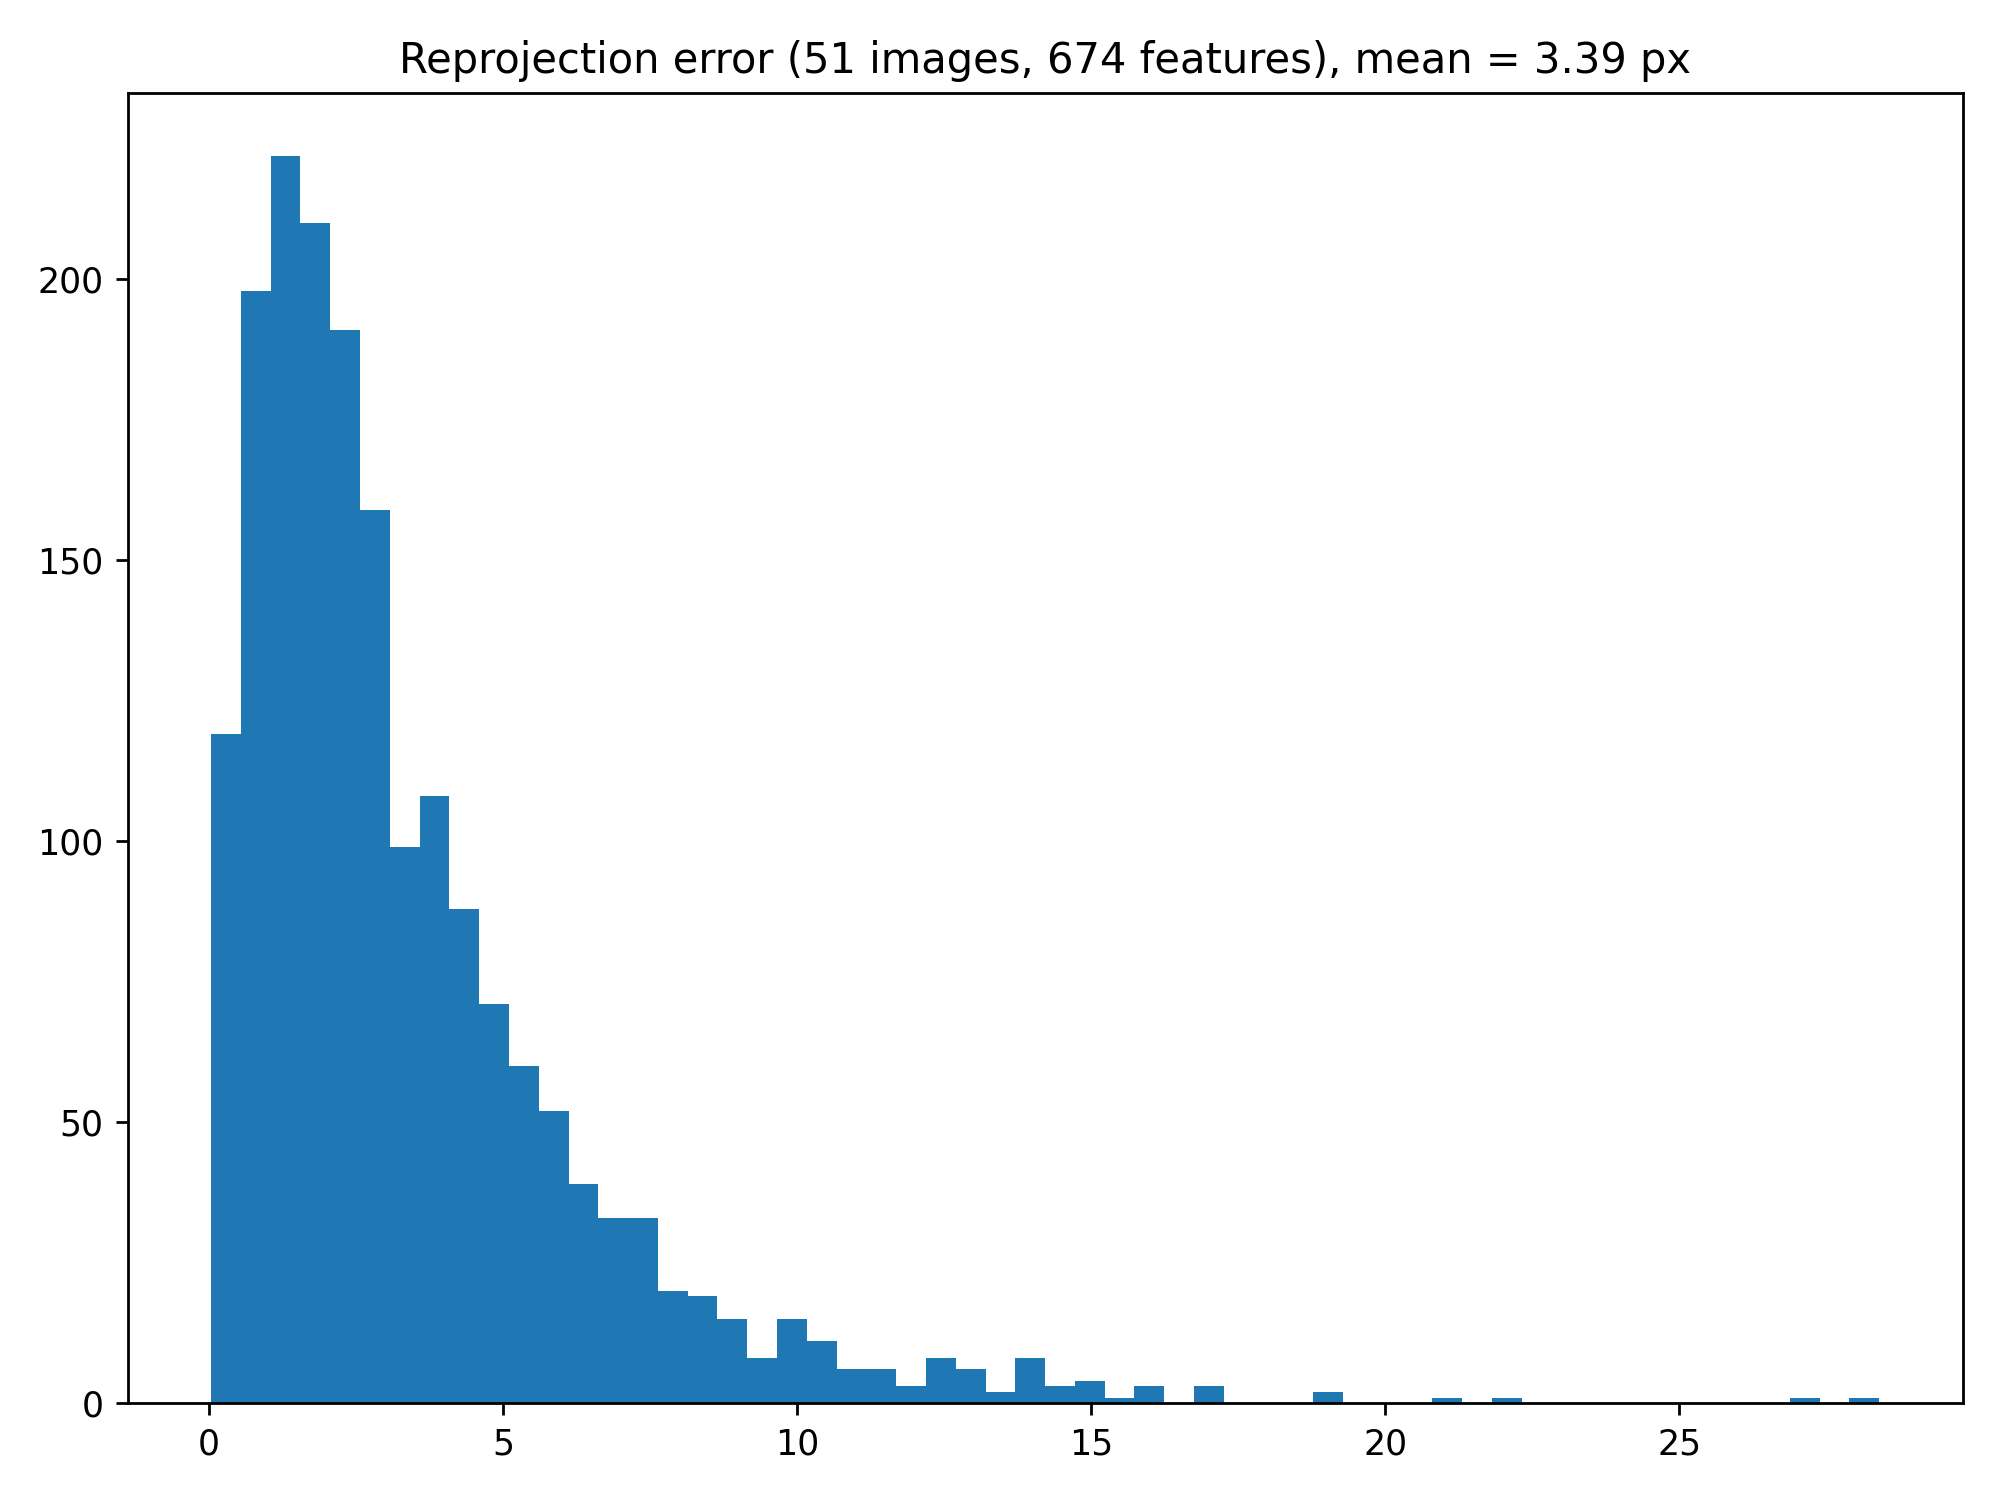

In [31]:
fig, ax = plt.subplots(figsize=(8,6))
reprojection_errors = fitter_all.reprojection_errors(fitter_all.camera_rotations, fitter_all.camera_translations, fitter_all.reco_locations)
reprojection_errors = linalg.norm(reprojection_errors.reshape((-1,2)), axis=1)
ax.hist(reprojection_errors, bins='auto')
ax.set_title("Reprojection error ({} images, {} features), mean = {:.2f} px".format(
    nimages, nfeatures, reprojection_errors.mean()))
fig.tight_layout()
fig.savefig(outputdir+"reprojection error.png")

In [32]:
# Sort the images/features by highest reprojection errors, for manual checking
print(np.array(np.unravel_index(np.argsort(linalg.norm(fitter_all.reprojected_locations()-fitter_all.image_feature_locations, axis=2).ravel()), (nimages, nfeatures))))
print(linalg.norm(fitter_all.reprojected_locations()-fitter_all.image_feature_locations, axis=2)[1, 90])
print(fitter_all.index_feature[3])

[[ 25  33  33 ...   6  35  19]
 [336 394 393 ... 535 437 355]]
0.0
06303-00


## Plots of differences between expected and reconstructed geometry

<IPython.core.display.Javascript object>


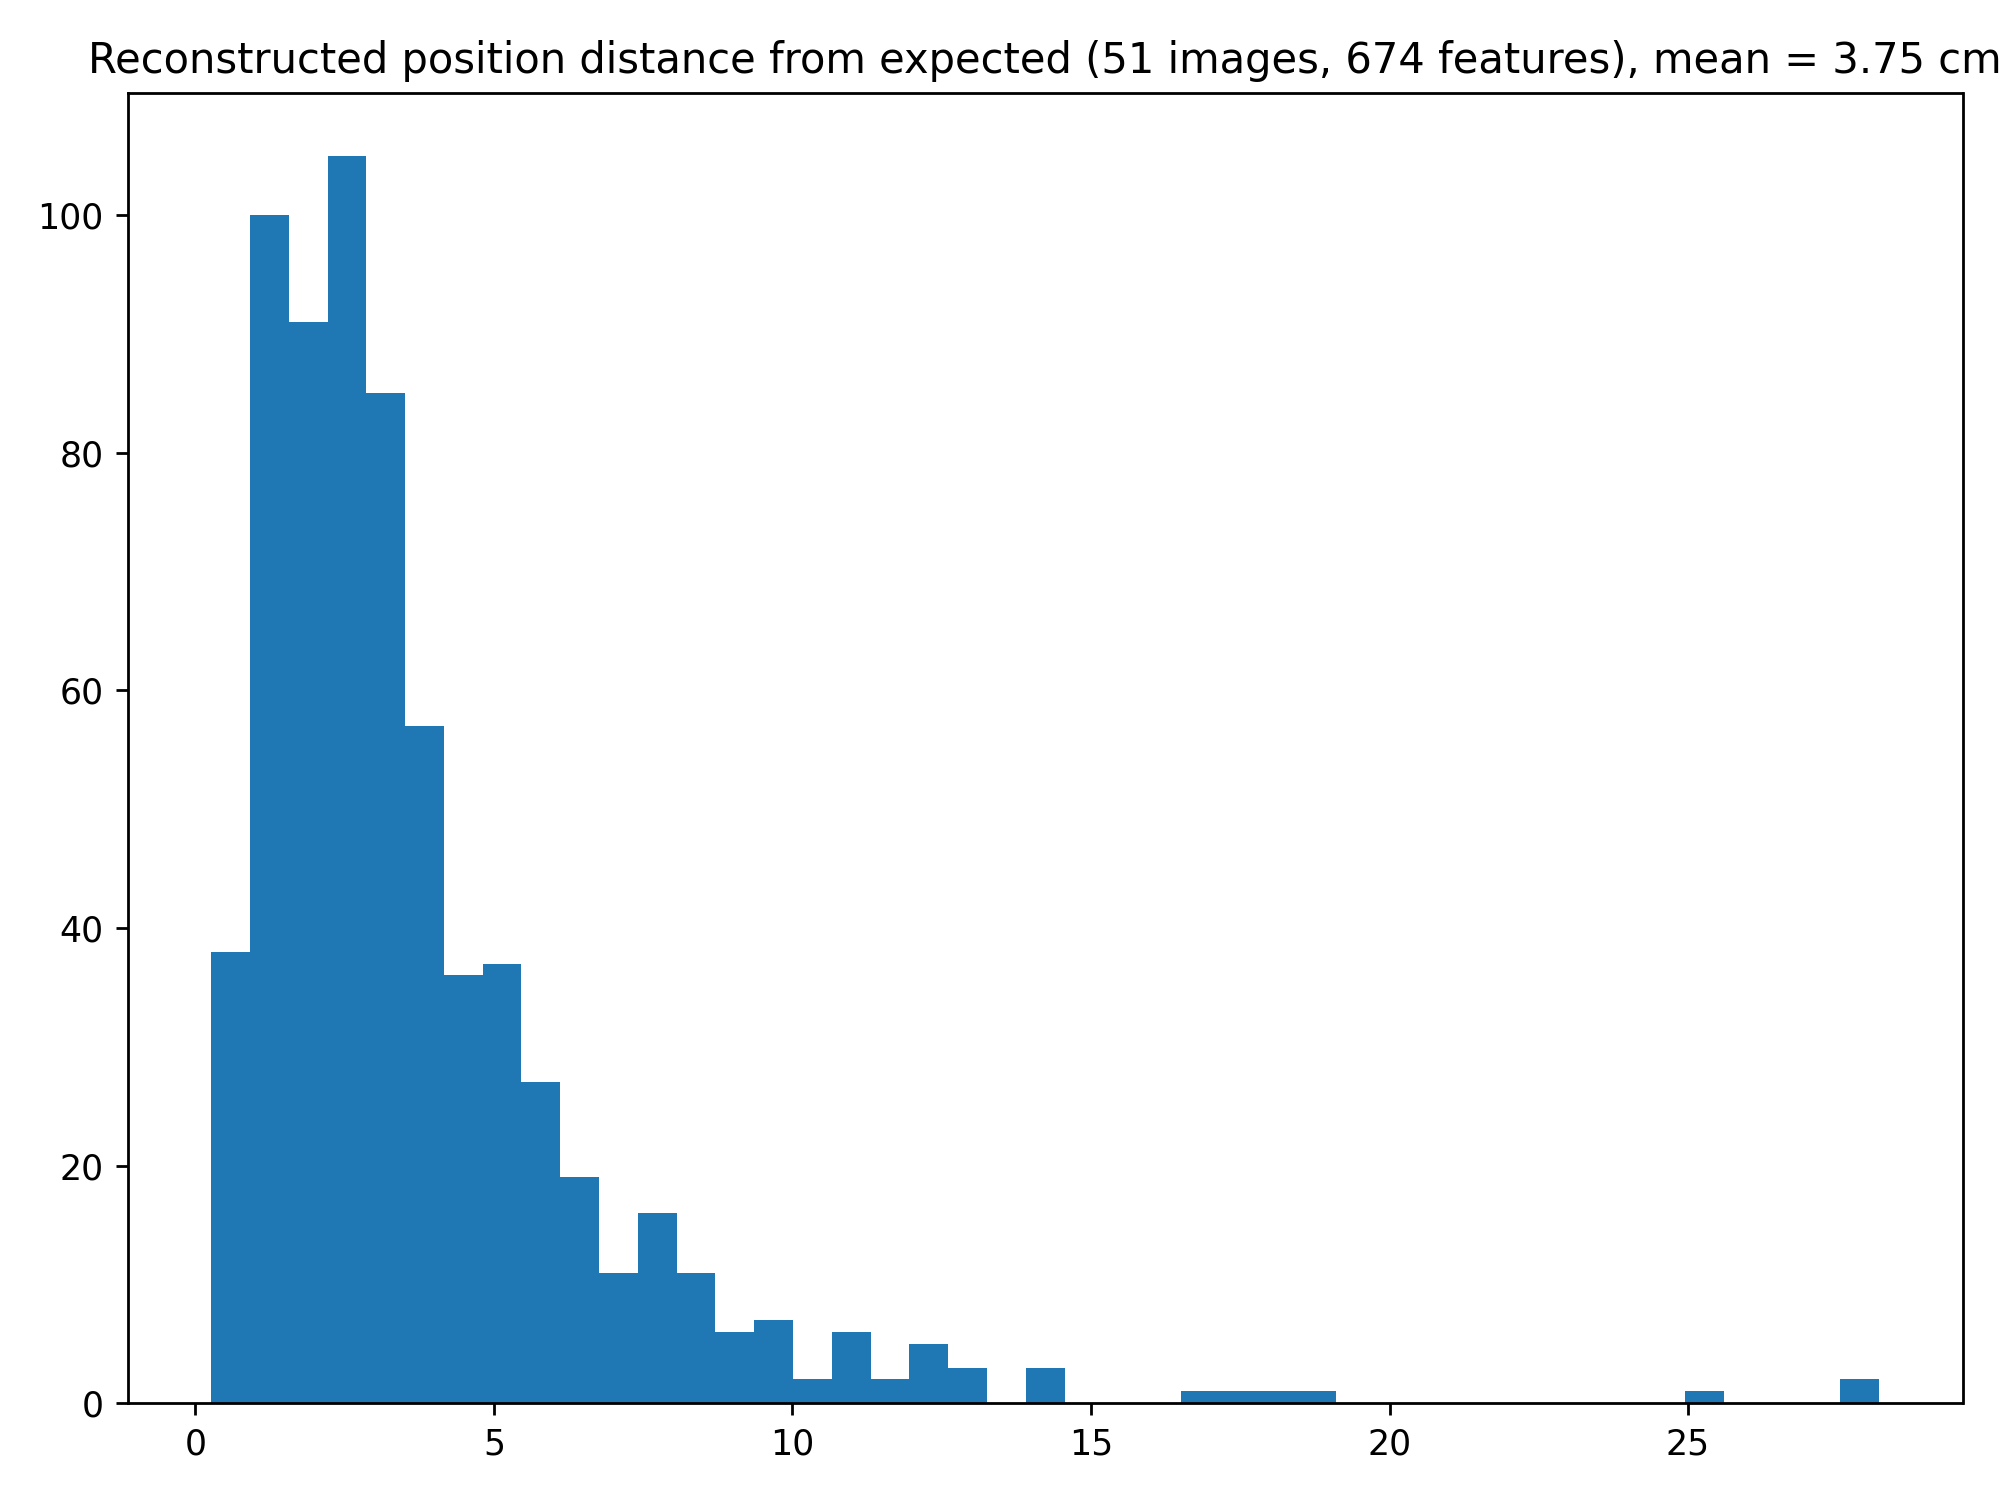

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(linalg.norm(errors, axis=1), bins='auto')
ax.set_title("Reconstructed position distance from expected ({} images, {} features), mean = {:.2f} cm".format(
    nimages, nfeatures, linalg.norm(errors, axis=1).mean()))
fig.tight_layout()
fig.savefig(outputdir+"distance from expected.png")

# End.

<IPython.core.display.Javascript object>


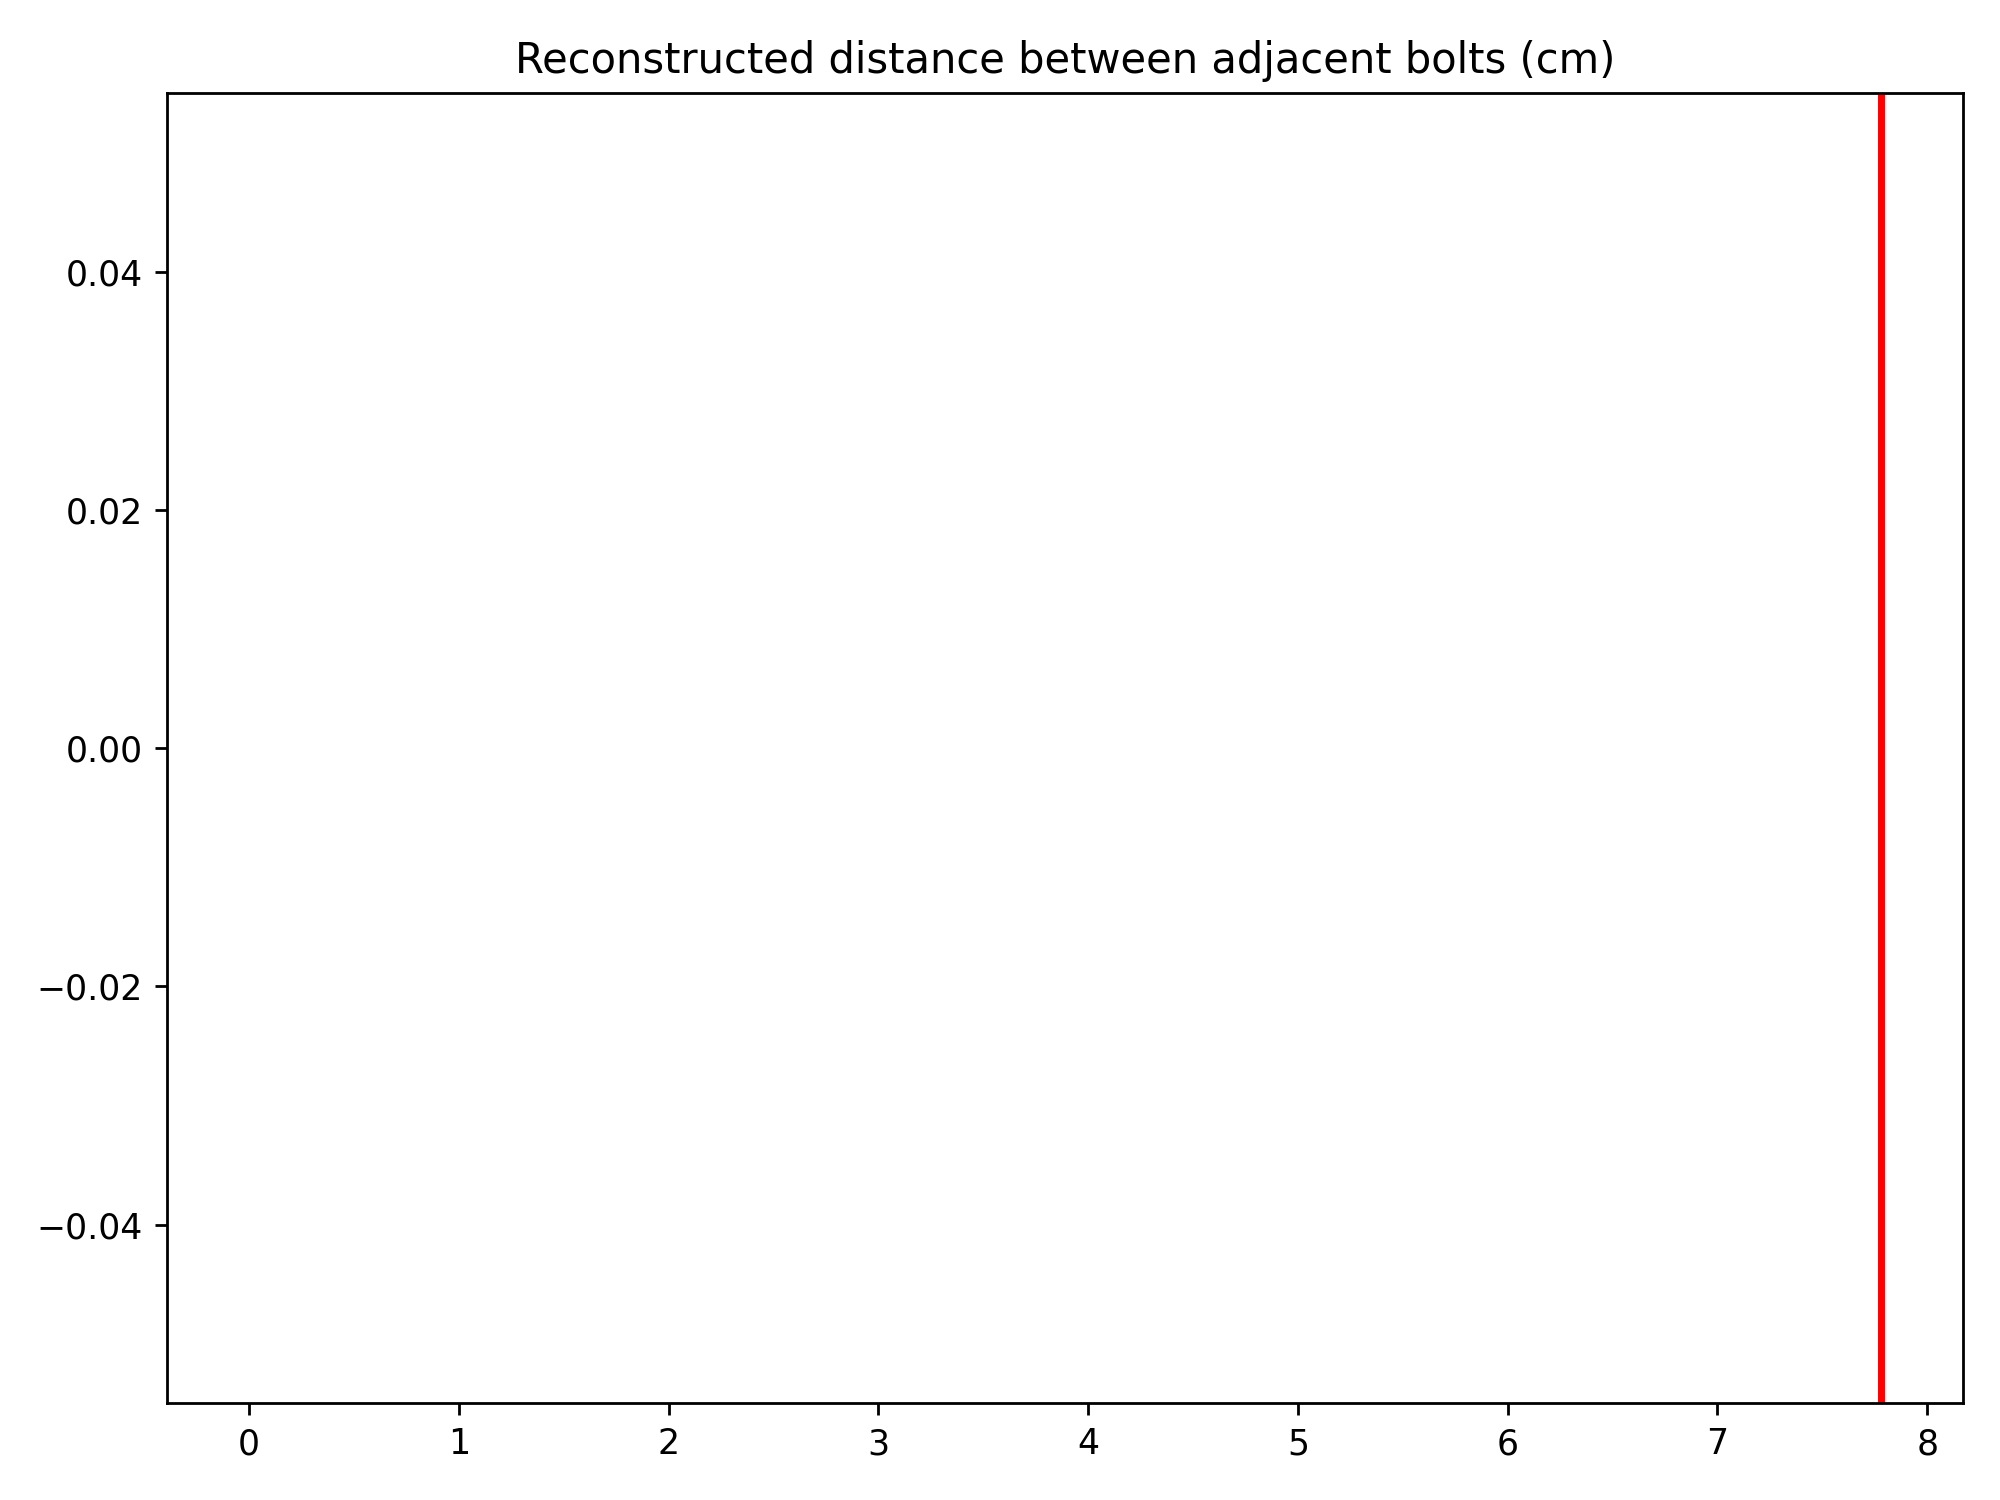

In [34]:
bolt_dict = {b: reco_transformed[fitter_all.feature_index[b]] for b in common_bolt_locations.keys()}
bolt_dists = sk.get_bolt_distances(bolt_dict)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(bolt_dists, bins='auto')
ax.set_title("Reconstructed distance between adjacent bolts (cm)")
ax.axvline(linewidth=2, color='r', x=sk.bolt_distance)
fig.tight_layout()

<IPython.core.display.Javascript object>


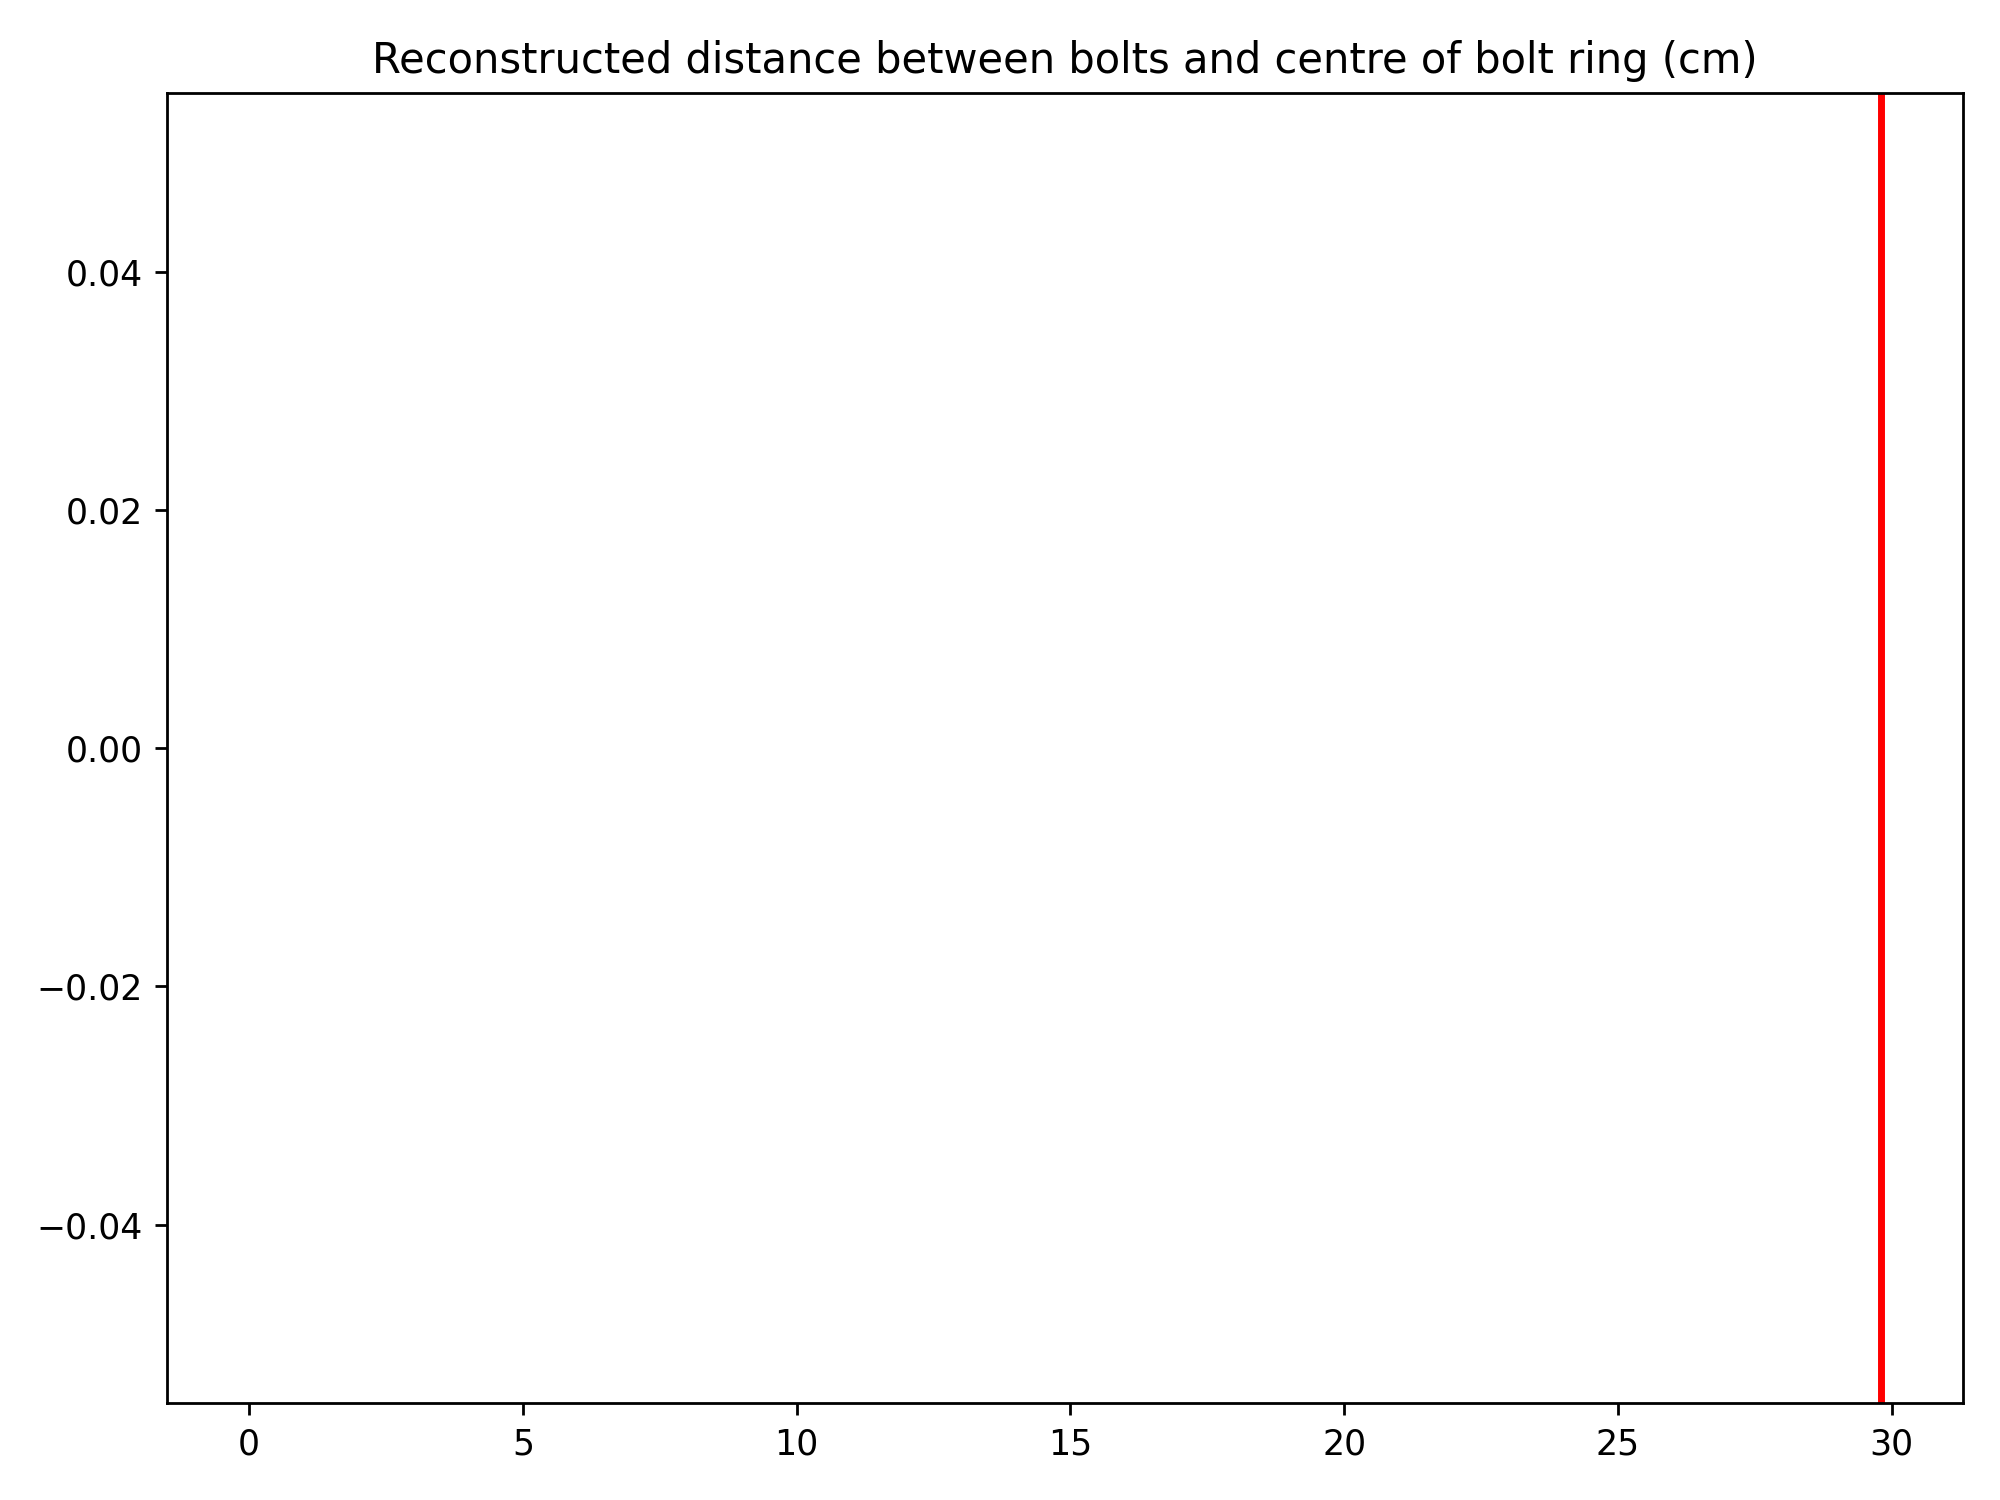

In [35]:
bolt_radii = sk.get_bolt_ring_radii(bolt_dict)
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(bolt_radii, bins='auto')
ax.set_title("Reconstructed distance between bolts and centre of bolt ring (cm)")
ax.axvline(linewidth=2, color='r', x=sk.bolt_ring_radius)
fig.tight_layout()

<IPython.core.display.Javascript object>


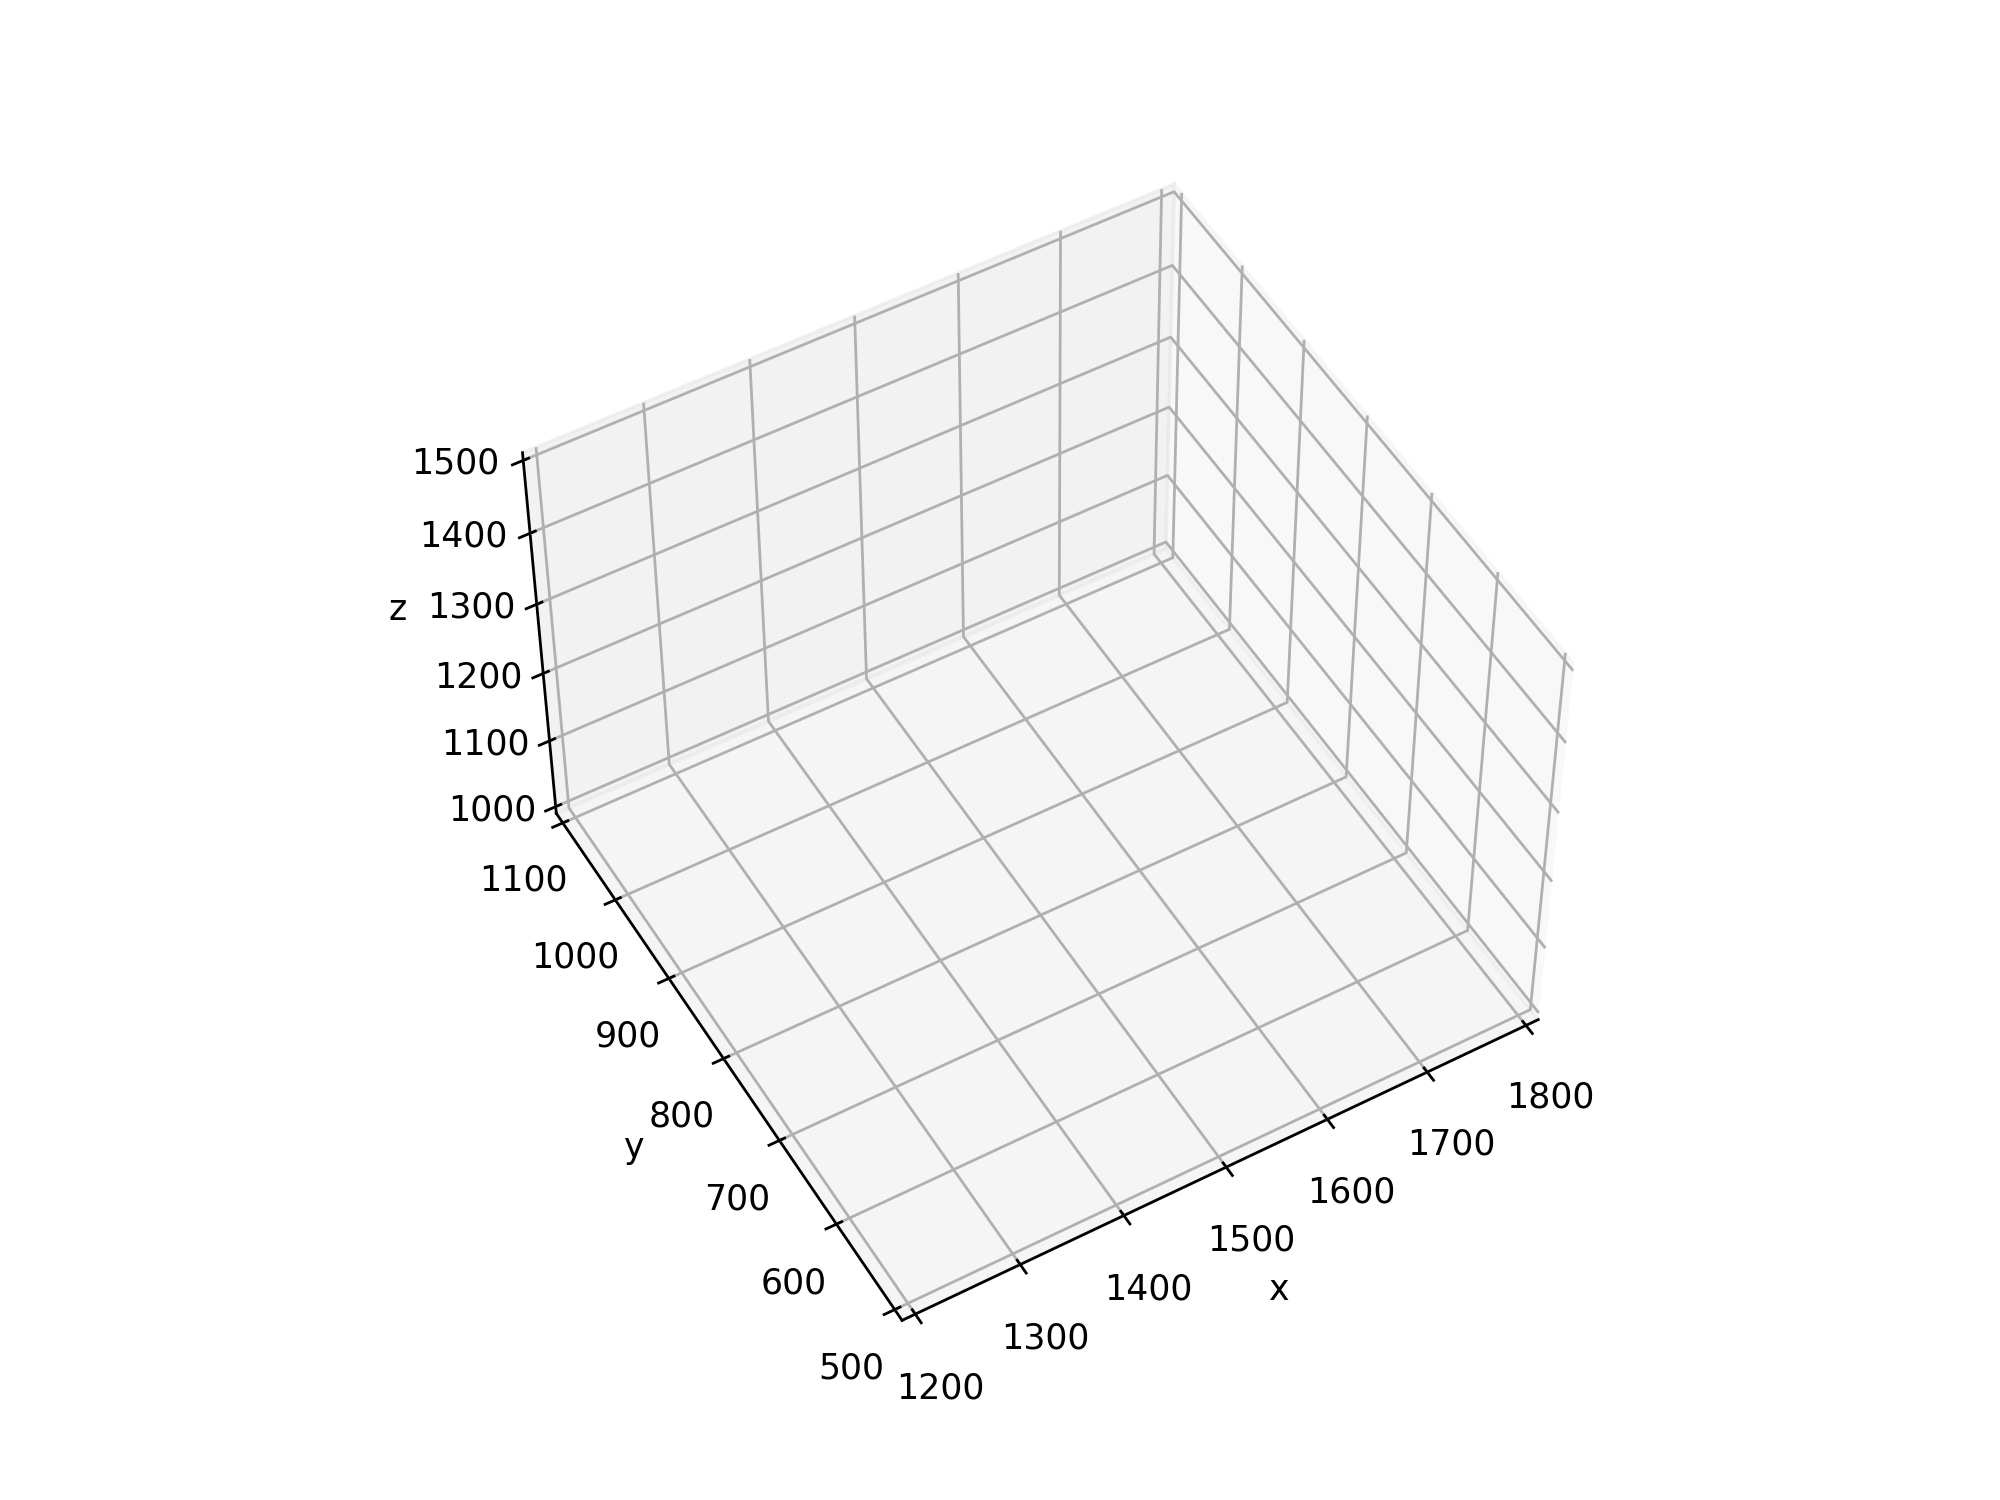

In [36]:
planes = sk.get_bolt_ring_planes(bolt_dict)
# flip planes if they're facing wrong direction (all normals should point towards tank centre)
plt.figure(figsize=(8,6))
ax = plt.subplot(111, projection='3d')
NN = 100
for pmt in sk.get_unique_pmt_ids(bolt_dict):
    pmt_bolt_coords = np.array([l for b, l in bolt_dict.items() if b[:5] == pmt])
    icolor = 'b' if int(pmt)>607 else 'orange' 
    ax.scatter(pmt_bolt_coords[:,0], pmt_bolt_coords[:,1], pmt_bolt_coords[:,2], color=icolor)
    p, n = planes[pmt]
    X,Y,Z = [[p[i]-n[i]*NN, p[i]+n[i]*NN] for i in range(3)]
    ax.plot(X,Y,Z,color=icolor)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(1200,1800)
ax.set_ylim(500, 1100)
ax.set_zlim(1000, 1500)
ax.view_init(50, 240)

In [37]:
####### calculate the mean normal angles
###### mean normal direction of left 12 and right 12
normals1 = np.array([n for pmt, (p, n) in planes.items() if int(pmt) <= 607])
normals2 = np.array([n for pmt, (p, n) in planes.items() if int(pmt) > 607])
N1 = np.mean(normals1, axis=0)
N2 = np.mean(normals2, axis=0)
print ('norm (avg of 12 angles)', N1, N2)

##### normal for fitting all 12 at once
N1_all = sk.get_supermodule_plane(bolt_dict, 451, 606)[1]
N2_all = sk.get_supermodule_plane(bolt_dict, 655, 810)[1]
print ('norm (simultanous fit 12 PMTs)', N1_all, N2_all)

###### difference
print ('diff (degrees)', np.degrees(np.arccos(np.dot(N1, N1_all))), np.degrees(np.arccos(np.dot(N1, N2_all))))

c:\users\micha\desktop\main\programs\python\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning:

Mean of empty slice.

c:\users\micha\desktop\main\programs\python\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\micha\Desktop\TRIUMF\calibration\Inter-photo labelling\danLabels\sk_geo_tools.py:65: RuntimeWarning:

Mean of empty slice.



norm (avg of 12 angles) nan nan


ValueError: expected matrix

In [ ]:
cos1=np.dot(normals1, N1_all)
cos2=np.dot(normals2, N2_all)
theta1=np.degrees(np.arccos(cos1))
theta2=np.degrees(np.arccos(cos2))
diff_2walls = np.degrees(np.arccos(np.dot(N1_all, N2_all)))

# print (cos1)
# print (cos2)
print ('Angle between 2 walls (using normals fitted to 12 PMTs simultaneously):',diff_2walls)
print (theta1)
print (theta2)

In [ ]:
plt.figure(figsize=(6,4))
ax = plt.subplot(111)
ax.hist(theta1, histtype='step', bins=10, range=(0,2.3),label='left 12 PMTs')
ax.hist(theta2, histtype='stepfilled', bins=10, range=(0,2.3),label='right 12 PMTs',alpha=0.5)
ax.set_xlabel('Angle from normal (degree)', fontsize=14)
ax.set_title('Angel between 2 groups (degrees):%.2f'%(diff_2walls), fontsize=14)
ax.legend( fontsize=14)
ax.set_ylabel('Number of PMTs', fontsize=14)
ax.set_ylim(0,4)
plt.tight_layout()